Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/home/alvaro/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [10]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [11]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  # dictionary assigns a unique index (base 1) to each word among the <vocabulary_size - 1> most common
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  # data will hold the corpus, but replacing words by their indexes
  data = list()
  # count of the number of appearances of words outside the <vocabulary_size - 1> most common
  unk_count = 0
  # builds data, as a sequence of indexes. In the process, updates unk_count
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  # reverse_dictionary links indexes with words
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [36]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2), (2, 2), (1, 4)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'originated', 'term', 'a', 'term', 'originated', 'as', 'of']

with num_skips = 2 and skip_window = 2:
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['anarchism', 'term', 'of', 'term', 'as', 'abuse', 'first', 'abuse']

with num_skips = 1 and skip_window = 4:
    batch: ['term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working']
    labels: ['used', 'originated', 'term', 'a', 'term', 'of', 'including', 'first']


Train a skip-gram model.

In [165]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  # embedding_lookup function retrieves rows of the params tensor.
  # The behavior is similar to using indexing with arrays in numpy. E.g. matix[[1, 2, 5, 8]]
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
    

  print(train_labels.shape, num_sampled, embed.shape)
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(128, 1) 64 (128, 128)


In [166]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
0
Average loss at step 0: 7.100097
Nearest to about: rocket, graeco, heliopause, bakkers, stripper, coppa, renovation, eftpos,
Nearest to years: abject, aldebaran, yehoshua, maximin, jorkens, consultancy, arne, interventionism,
Nearest to of: seydlitz, ethics, quarrels, winn, attu, fertilization, dazzling, medell,
Nearest to known: seminole, session, staphylococcus, bundesl, tf, waldo, dispersive, node,
Nearest to system: validating, quintus, collaborative, sheds, comedienne, ripley, unwitting, jarvis,
Nearest to would: centralized, drilling, defect, cobbler, shrewd, clayton, chamorro, recycling,
Nearest to often: siona, rioting, hadassah, gardens, petersburg, congressmen, champlain, granites,
Nearest to however: french, quartier, blond, appalachians, debris, protesting, cousins, tiny,
Nearest to had: neill, gareth, euripides, magnification, mondale, modesty, typographic, unoccupied,
Nearest to at: brahmagupta, cygnus, caius, bremer, unborn, equipped, typewriter, sextilis,


1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627
1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752


KeyboardInterrupt: 

In [42]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

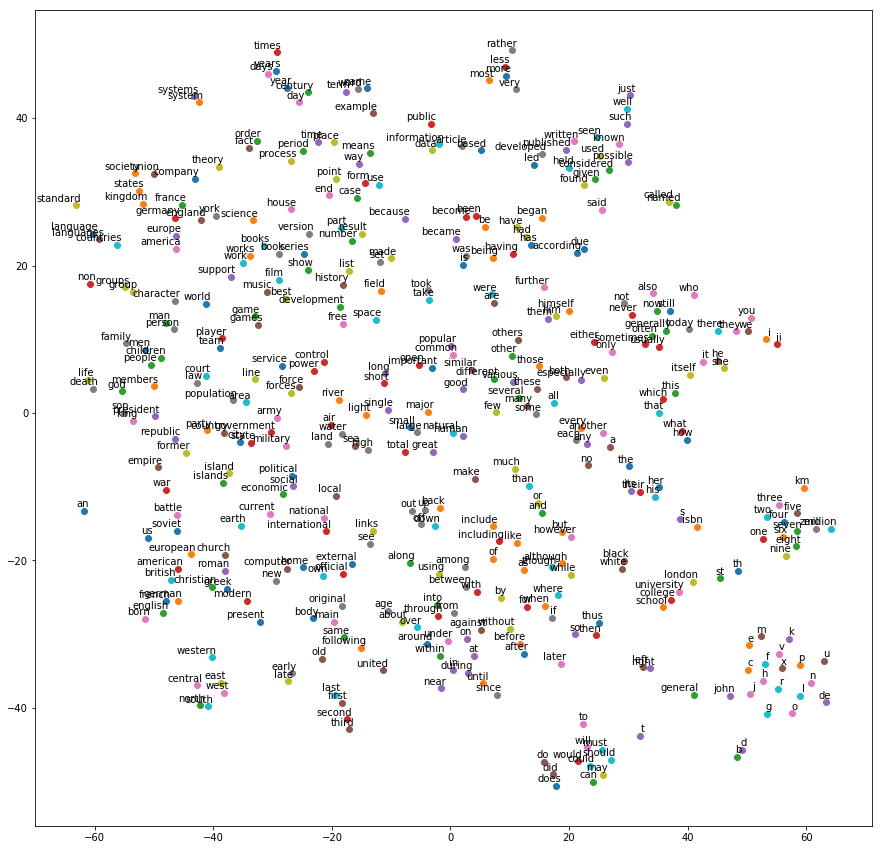

In [43]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [167]:
np.reshape(np.array([1, 2, 3]), [-1, 1])

array([[1],
       [2],
       [3]])

In [187]:
data_index = 0
def create_cbow_batch(window_size, step_size, batch_size):
    global data_index
    contexts = []
    targets = []
    for _ in range(batch_size):
        span = 2*window_size + 1
        target_word = data[data_index + window_size]
    
        context_words = data[data_index:data_index + window_size] +\
                        data[data_index + window_size + 1:data_index + window_size*2 + 1]
        data_index += step_size
        contexts.append(context_words)
        targets.append(target_word)
    return np.array(contexts), np.array(targets)

In [169]:
for window, step in [(2, 1), (2, 2), (4, 1), (4, 2)]:
    contexts, targets = create_cbow_batch(window, step, 2)
    for context, target in zip(contexts, targets):
        print([reverse_dictionary[i] for i in context], reverse_dictionary[target])

['anarchism', 'originated', 'a', 'term'] as
['originated', 'as', 'term', 'of'] a
['as', 'a', 'of', 'abuse'] term
['term', 'of', 'first', 'used'] abuse
['abuse', 'first', 'used', 'against', 'working', 'class', 'radicals', 'including'] early
['first', 'used', 'against', 'early', 'class', 'radicals', 'including', 'the'] working
['used', 'against', 'early', 'working', 'radicals', 'including', 'the', 'diggers'] class
['early', 'working', 'class', 'radicals', 'the', 'diggers', 'of', 'the'] including


In [190]:
batch_size = 128
window_size = 2
embedding_size = 128
num_samples = 50

num_valid = 10
valid_examples = np.array([np.random.randint(100) for _ in range(num_valid)])

graph = tf.Graph()
with graph.as_default():
    
    train_dataset = tf.placeholder(tf.int32, [batch_size, window_size*2])
    train_labels = tf.placeholder(tf.int32, [batch_size, 1])
    
    valid_dataset = tf.constant(valid_examples, dtype=np.int32)
    
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1, 1))
    input_vectors = tf.reduc[
        tf.reduce_sum(tf.nn.embedding_lookup(embeddings, train_dataset[i, :]), axis=0)
        for i in range(batch_size)
    ]
    inputs = tf.convert_to_tensor(input_vectors)
            
    weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], mean=0.0, stddev=1/math.sqrt(embedding_size))
    )
    biases = tf.Variable(tf.zeros(vocabulary_size))
    
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=weights, biases=biases, inputs=inputs,
                                                     labels=train_labels, num_sampled=num_samples,
                                                     num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1).minimize(loss)
                             

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
    norm_embeddings = embeddings / norm

    embeddings_valid = tf.nn.embedding_lookup(embeddings, valid_dataset)
    similarity = tf.matmul(embeddings_valid, tf.transpose(norm_embeddings))
    print(similarity.get_shape())

(10, 50000)


In [200]:
batch_size = 128
window_size = 2
embedding_size = 128
num_samples = 50

num_valid = 10
valid_examples = np.array([np.random.randint(100) for _ in range(num_valid)])

graph = tf.Graph()
with graph.as_default():
    
    train_dataset = tf.placeholder(tf.int32, [batch_size, window_size*2])
    train_labels = tf.placeholder(tf.int32, [batch_size, 1])
    
    valid_dataset = tf.constant(valid_examples, dtype=np.int32)
    
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1, 1))
    
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    inputs = tf.reduce_sum(embeds, 1)
            
    weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], mean=0.0, stddev=1/math.sqrt(embedding_size))
    )
    biases = tf.Variable(tf.zeros(vocabulary_size))
    
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=weights, biases=biases, inputs=inputs,
                                                     labels=train_labels, num_sampled=num_samples,
                                                     num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1).minimize(loss)
                             

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
    norm_embeddings = embeddings / norm

    embeddings_valid = tf.nn.embedding_lookup(embeddings, valid_dataset)
    similarity = tf.matmul(embeddings_valid, tf.transpose(norm_embeddings))
    print(similarity.get_shape())

(10, 50000)


In [203]:
step_size = 1
num_steps = 100001

with tf.Session(graph=graph) as session, tf.device('/cpu:0'):
    tf.global_variables_initializer().run()

    for step in range(num_steps):
        contexts, targets = create_cbow_batch(window_size, step_size, batch_size)
        
        feed_dict = {
            train_dataset: contexts,
            train_labels: np.reshape(targets, [targets.shape[0], 1])
        }
    
        _, l, sim = session.run([optimizer, loss, similarity], feed_dict=feed_dict)
        
        if step and not step % 100:
            print('\nLoss at {}: {}'.format(step, l))
        
        if step and not step % 200:
            max_similarities = (-sim).argsort(axis=1)
            for j in range(num_valid):
                best_indexes = max_similarities[j, 1:8]
                v = reverse_dictionary[valid_dataset.eval()[j]]
                best_words = [reverse_dictionary[j] for j in best_indexes]
                print('Closest to {}: {}'.format(v, best_words))


Loss at 100: 5.541321277618408

Loss at 200: 5.051457405090332
Closest to also: ['seabed', 'counters', 'signifier', 'coalesced', 'internetworking', 'zf', 'abusive']
Closest to used: ['pt', 'astronautics', 'hedonistic', 'terminator', 'kyiv', 'banishment', 'asserted']
Closest to nine: ['kinases', 'charging', 'teleprinter', 'marginalized', 'homophobic', 'extensionality', 'isuzu']
Closest to zero: ['disposing', 'devine', 'ghamdi', 'allusion', 'shake', 'dhabi', 'towns']
Closest to be: ['management', 'darius', 'conjuring', 'ahab', 'cyclase', 'phoenicians', 'capitan']
Closest to will: ['bhp', 'behaviorist', 'temperament', 'beat', 'eu', 'numerous', 'condenses']
Closest to system: ['wages', 'newtons', 'triplets', 'regnant', 'dostoevsky', 'savages', 'ellipse']
Closest to however: ['predictably', 'inward', 'entangled', 'extensive', 'loneliness', 'martius', 'objectivism']
Closest to up: ['khayyam', 'garth', 'collaborated', 'bruin', 'dao', 'phylogenetics', 'sticky']
Closest to than: ['sempronius',


Loss at 1700: 4.03339958190918

Loss at 1800: 4.03095817565918
Closest to also: ['seabed', 'cambridgeshire', 'gematria', 'farm', 'saxo', 'useable', 'organisers']
Closest to used: ['chickenpox', 'editor', 'astronautics', 'athanasius', 'trillion', 'sanger', 'aveiro']
Closest to nine: ['eight', 'six', 'seven', 'five', 'zero', 'two', 'three']
Closest to zero: ['six', 'seven', 'eight', 'five', 'three', 'two', 'nine']
Closest to be: ['is', 'jurassic', 'have', 'kobayashi', 'conjuring', 'sevilla', 'melvyn']
Closest to will: ['bhp', 'massless', 'beat', 'porting', 'temperaments', 'behaviorist', 'imams']
Closest to system: ['clc', 'newtons', 'triplets', 'wages', 'xerxes', 'savages', 'democide']
Closest to however: ['keyword', 'pubmed', 'predictably', 'baldrick', 'martius', 'bestselling', 'entangled']
Closest to up: ['encoders', 'protocols', 'khayyam', 'garth', 'collaborated', 'brancusi', 'kilmister']
Closest to than: ['ruthenia', 'sempronius', 'masefield', 'airstrip', 'snake', 'port', 'impresari


Loss at 3500: 4.492082595825195

Loss at 3600: 3.1651501655578613
Closest to also: ['ftl', 'seabed', 'refraining', 'accelerating', 'fat', 'diputados', 'tosefta']
Closest to used: ['trillion', 'editor', 'interpreted', 'habib', 'anastasio', 'tempting', 'polyphyletic']
Closest to nine: ['eight', 'seven', 'zero', 'three', 'six', 'five', 'four']
Closest to zero: ['three', 'five', 'six', 'eight', 'seven', 'nine', 'four']
Closest to be: ['have', 'ernest', 'ortho', 'conjuring', 'mole', 'vocal', 'msc']
Closest to will: ['would', 'massless', 'beat', 'should', 'bhp', 'imams', 'can']
Closest to system: ['clc', 'newtons', 'xerxes', 'savages', 'encountered', 'finley', 'decomposes']
Closest to however: ['determinative', 'groin', 'mathieu', 'predictably', 'martius', 'ported', 'underscored']
Closest to up: ['brancusi', 'protocols', 'encoders', 'oblast', 'kilmister', 'dictate', 'tj']
Closest to than: ['ruthenia', 'acceptor', 'iole', 'but', 'ilm', 'taurus', 'port']

Loss at 3700: 4.247086524963379

Loss


Loss at 5300: 3.8885607719421387

Loss at 5400: 3.563113212585449
Closest to also: ['ftl', 'carats', 'seabed', 'often', 'hemispheric', 'brahma', 'accelerating']
Closest to used: ['majorana', 'emoticon', 'downwards', 'considered', 'editor', 'interpreted', 'triton']
Closest to nine: ['eight', 'five', 'six', 'seven', 'three', 'four', 'zero']
Closest to zero: ['three', 'nine', 'four', 'eight', 'six', 'five', 'two']
Closest to be: ['have', 'galvanic', 'counterintelligence', 'ortho', 'mole', 'ernest', 'prentice']
Closest to will: ['would', 'can', 'massless', 'should', 'to', 'may', 'might']
Closest to system: ['xerxes', 'clc', 'savages', 'encountered', 'finley', 'newtons', 'jacob']
Closest to however: ['baldrick', 'korea', 'groin', 'brummell', 'enclosing', 'determinative', 'epiphanes']
Closest to up: ['brancusi', 'protocols', 'carotenoids', 'them', 'tj', 'kilmister', 'encoders']
Closest to than: ['ruthenia', 'or', 'santorini', 'neutrino', 'jul', 'ilm', 'equinoxes']

Loss at 5500: 2.965209960


Loss at 7100: 3.449471950531006

Loss at 7200: 4.265704154968262
Closest to also: ['defy', 'healed', 'seabed', 'stagnant', 'arizona', 'that', 'seeds']
Closest to used: ['found', 'formed', 'considered', 'called', 'warden', 'bourgeois', 'known']
Closest to nine: ['eight', 'five', 'six', 'seven', 'zero', 'four', 'three']
Closest to zero: ['nine', 'six', 'eight', 'four', 'two', 'five', 'three']
Closest to be: ['have', 'were', 'ortho', 'make', 'refer', 'was', 'galvanic']
Closest to will: ['can', 'would', 'may', 'should', 'must', 'could', 'might']
Closest to system: ['savages', 'xerxes', 'encountered', 'clc', 'fresh', 'democide', 'finley']
Closest to however: ['groin', 'enclosing', 'changed', 'determinative', 'secretory', 'hindered', 'baldrick']
Closest to up: ['them', 'brancusi', 'carotenoids', 'collaborated', 'humanistic', 'dictate', 'tj']
Closest to than: ['or', 'ruthenia', 'but', 'santorini', 'neutrino', 'clowning', 'reddy']

Loss at 7300: 4.29151725769043

Loss at 7400: 3.1965270042419


Loss at 8900: 2.9244956970214844

Loss at 9000: 2.6852197647094727
Closest to also: ['never', 'stagnant', 'fat', 'carats', 'defy', 'ftl', 'arizona']
Closest to used: ['found', 'considered', 'called', 'warden', 'formed', 'anastasio', 'habib']
Closest to nine: ['eight', 'five', 'six', 'three', 'four', 'seven', 'two']
Closest to zero: ['eight', 'three', 'four', 'seven', 'five', 'nine', 'two']
Closest to be: ['have', 'galvanic', 'refer', 'make', 'obtain', 'come', 'teenager']
Closest to will: ['would', 'can', 'could', 'may', 'should', 'must', 'cannot']
Closest to system: ['savages', 'xerxes', 'clc', 'montesquieu', 'encountered', 'fresh', 'guin']
Closest to however: ['but', 'groin', 'enclosing', 'and', 'because', 'jealously', 'privatisation']
Closest to up: ['them', 'brancusi', 'shaw', 'semiconductors', 'binaries', 'dictate', 'encoders']
Closest to than: ['ruthenia', 'or', 'santorini', 'neutrino', 'but', 'maeterlinck', 'clowning']

Loss at 9100: 3.5026888847351074

Loss at 9200: 2.666845321


Loss at 10700: 2.848942756652832

Loss at 10800: 3.6418349742889404
Closest to also: ['polymorphism', 'which', 'ordain', 'windmill', 'pepe', 'speght', 'katha']
Closest to used: ['found', 'considered', 'known', 'referred', 'called', 'anastasio', 'formed']
Closest to nine: ['eight', 'seven', 'six', 'five', 'four', 'two', 'zero']
Closest to zero: ['two', 'five', 'seven', 'eight', 'four', 'six', 'nine']
Closest to be: ['have', 'refer', 'galvanic', 'ortho', 'were', 'been', 'become']
Closest to will: ['would', 'can', 'may', 'could', 'should', 'must', 'cannot']
Closest to system: ['clc', 'homered', 'xerxes', 'savages', 'systems', 'slides', 'functionally']
Closest to however: ['but', 'hives', 'groin', 'backspace', 'robe', 'enclosing', 'ziv']
Closest to up: ['them', 'shaw', 'humanistic', 'brancusi', 'binaries', 'semiconductors', 'infibulation']
Closest to than: ['ruthenia', 'or', 'reddy', 'santorini', 'denotation', 'ilm', 'maeterlinck']

Loss at 10900: 2.8871207237243652

Loss at 11000: 3.6334


Loss at 12500: 2.9054503440856934

Loss at 12600: 3.1178553104400635
Closest to also: ['which', 'often', 'never', 'polymorphism', 'disambiguation', 'lemming', 'cloned']
Closest to used: ['found', 'considered', 'known', 'formed', 'described', 'referred', 'anastasio']
Closest to nine: ['seven', 'eight', 'six', 'four', 'three', 'five', 'zero']
Closest to zero: ['seven', 'six', 'four', 'three', 'eight', 'two', 'nine']
Closest to be: ['refer', 'have', 'being', 'make', 'galvanic', 'duma', 'ortho']
Closest to will: ['would', 'can', 'may', 'could', 'must', 'should', 'might']
Closest to system: ['systems', 'clc', 'slides', 'xerxes', 'homered', 'savages', 'montesquieu']
Closest to however: ['but', 'hives', 'so', 'umts', 'although', 'and', 'because']
Closest to up: ['them', 'shaw', 'brancusi', 'protocols', 'homers', 'him', 'infibulation']
Closest to than: ['ruthenia', 'or', 'reddy', 'santorini', 'denotation', 'aquarists', 'cimmeria']

Loss at 12700: 3.1579222679138184

Loss at 12800: 2.725304841


Loss at 14300: 3.1631855964660645

Loss at 14400: 3.4087183475494385
Closest to also: ['often', 'still', 'disambiguation', 'which', 'carats', 'pepe', 'below']
Closest to used: ['found', 'known', 'considered', 'called', 'described', 'designed', 'anastasio']
Closest to nine: ['seven', 'eight', 'six', 'five', 'zero', 'four', 'three']
Closest to zero: ['seven', 'four', 'nine', 'six', 'eight', 'two', 'five']
Closest to be: ['refer', 'have', 'being', 'stalled', 'duma', 'produce', 'diploma']
Closest to will: ['would', 'can', 'may', 'could', 'must', 'should', 'might']
Closest to system: ['systems', 'bfbs', 'homered', 'abide', 'sweetness', 'decorative', 'feodor']
Closest to however: ['but', 'because', 'hives', 'chen', 'canaris', 'pelt', 'borrowers']
Closest to up: ['them', 'shaw', 'infibulation', 'homers', 'gaslight', 'back', 'shocked']
Closest to than: ['or', 'ruthenia', 'santorini', 'reddy', 'cimmeria', 'denotation', 'leopoldo']

Loss at 14500: 3.244966506958008

Loss at 14600: 4.16219711303


Loss at 16100: 4.148778915405273

Loss at 16200: 3.225130558013916
Closest to also: ['often', 'brahma', 'below', 'pepe', 'disambiguation', 'kubitzki', 'cpi']
Closest to used: ['considered', 'found', 'known', 'designed', 'called', 'referred', 'seen']
Closest to nine: ['eight', 'seven', 'three', 'zero', 'four', 'six', 'two']
Closest to zero: ['nine', 'seven', 'five', 'four', 'three', 'eight', 'six']
Closest to be: ['have', 'refer', 'being', 'produce', 'diploma', 'counterintelligence', 'ortho']
Closest to will: ['would', 'can', 'could', 'may', 'must', 'should', 'might']
Closest to system: ['systems', 'homered', 'functionally', 'xerxes', 'clc', 'feodor', 'decorative']
Closest to however: ['although', 'though', 'but', 'hives', 'because', 'while', 'canaris']
Closest to up: ['them', 'shaw', 'binaries', 'back', 'gaslight', 'shocked', 'telephones']
Closest to than: ['or', 'ruthenia', 'denotation', 'santorini', 'suggesting', 'cherbourg', 'finn']

Loss at 16300: 3.2666549682617188

Loss at 16400


Loss at 17900: 2.798574924468994

Loss at 18000: 3.2643017768859863
Closest to also: ['often', 'brahma', 'stagnant', 'disambiguation', 'below', 'coppersmith', 'which']
Closest to used: ['considered', 'found', 'referred', 'called', 'known', 'made', 'designed']
Closest to nine: ['eight', 'seven', 'six', 'four', 'zero', 'five', 'three']
Closest to zero: ['four', 'eight', 'six', 'seven', 'nine', 'five', 'three']
Closest to be: ['being', 'produce', 'refer', 'have', 'hs', 'serve', 'opposites']
Closest to will: ['would', 'could', 'may', 'can', 'should', 'must', 'might']
Closest to system: ['systems', 'homered', 'montesquieu', 'functionally', 'abide', 'clc', 'baines']
Closest to however: ['although', 'but', 'though', 'while', 'because', 'monopoles', 'hives']
Closest to up: ['them', 'him', 'shaw', 'shocked', 'out', 'dude', 'schiavo']
Closest to than: ['ruthenia', 'denotation', 'or', 'suggesting', 'jul', 'cimmeria', 'leopoldo']

Loss at 18100: 3.690098762512207

Loss at 18200: 3.402346134185791


Loss at 19700: 3.85025954246521

Loss at 19800: 3.131716728210449
Closest to also: ['below', 'disambiguation', 'often', 'still', 'weighed', 'explanation', 'carats']
Closest to used: ['referred', 'found', 'considered', 'known', 'designed', 'called', 'seen']
Closest to nine: ['eight', 'seven', 'four', 'six', 'zero', 'five', 'three']
Closest to zero: ['six', 'five', 'eight', 'seven', 'nine', 'three', 'four']
Closest to be: ['refer', 'being', 'were', 'serve', 'have', 'counterintelligence', 'ortho']
Closest to will: ['could', 'would', 'may', 'can', 'should', 'must', 'might']
Closest to system: ['systems', 'clc', 'functionally', 'vlaams', 'montesquieu', 'baines', 'homered']
Closest to however: ['but', 'although', 'jealously', 'moonshine', 'epiphanes', 'while', 'monopoles']
Closest to up: ['them', 'him', 'out', 'shaw', 'equaled', 'tuning', 'shocked']
Closest to than: ['ruthenia', 'denotation', 'jul', 'cimmeria', 'reddy', 'tasteless', 'maeterlinck']

Loss at 19900: 4.398093223571777

Loss at 


Loss at 21500: 3.2612714767456055

Loss at 21600: 2.539494514465332
Closest to also: ['below', 'often', 'still', 'which', 'usually', 'carats', 'now']
Closest to used: ['found', 'designed', 'considered', 'known', 'referred', 'anastasio', 'seen']
Closest to nine: ['eight', 'seven', 'zero', 'six', 'four', 'five', 'three']
Closest to zero: ['eight', 'five', 'nine', 'seven', 'four', 'two', 'six']
Closest to be: ['being', 'refer', 'have', 'counterintelligence', 'serve', 'exist', 'ortho']
Closest to will: ['would', 'can', 'could', 'may', 'should', 'must', 'might']
Closest to system: ['systems', 'clc', 'vlaams', 'abide', 'baines', 'homered', 'hatch']
Closest to however: ['but', 'although', 'though', 'while', 'pelt', 'collating', 'because']
Closest to up: ['out', 'them', 'him', 'shaw', 'equaled', 'tuning', 'shocked']
Closest to than: ['jul', 'or', 'denotation', 'subgenius', 'ruthenia', 'but', 'santorini']

Loss at 21700: 3.2026147842407227

Loss at 21800: 2.9827866554260254
Closest to also: ['

KeyboardInterrupt: 

In [202]:
tf.device?